# qStorm Option Pricing Surface Visualization

This notebook generates publication-quality visualizations of the qStorm option pricing surface.

**Outputs:**
- `qstorm_surface.png` - Main 3D surface plot with transparent background
- `qstorm_multiview.png` - Three different viewing angles
- `qstorm_contours.png` - 2D contour plots
- `qstorm_all_views.png` - Six different viewing angles

All images are saved with transparent backgrounds at 300 DPI for publication use.


In [1]:
import json
import torch
import numpy as np
import random
from q_storm.StormSampler import StormSampler
from varpi.tain_varpi import VarPi

device = "cuda" if torch.cuda.is_available() else "cpu"

with open('config.json') as f:
    config = json.load(f)
    
taus = config["general"]["quantiles"]

sampler = StormSampler(device, taus)
# set seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

/home/dev/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-02-09 14:31:39,364] Using an existing study with name 'wasserstein_distance_qlstm' instead of creating a new one.


In [2]:
q_strom = torch.load("models/q_storm.pth", weights_only=False)
varpi = torch.load("models/varpi.pth", weights_only=False)

In [3]:
sampled_point = sampler.sample(1, add_noise=False)
S_prime_test = torch.linspace(0, 5, 100).view(-1, 1)
tau_test = torch.linspace(0, 30, 100).view(-1, 1)
S_grid, T_grid = torch.meshgrid(S_prime_test.squeeze(), tau_test.squeeze())
S_grid = S_grid.reshape(-1, 1)
T_grid = T_grid.reshape(-1, 1)
rf = sampled_point["rf"]
varphi_q = sampled_point["varphi_q"]

# Expand rf to match the grid shape (broadcasting across S_grid and T_grid)
rf_grid = rf.expand(S_grid.shape[0], 1)

S_grid = S_grid.to(device)
T_grid = T_grid.to(device)
rf_grid = rf_grid.to(device)
print(varphi_q.mean())

tensor(-0.0062, device='cuda:0', grad_fn=<MeanBackward0>)


/home/dev/.local/lib/python3.10/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4381.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
T_prime_grid = torch.max(T_grid, torch.ones_like(T_grid)*15)
t_prime_grid = T_grid/T_prime_grid
T_prime_grid = T_prime_grid/30
varphi_q_grid = varphi_q.expand(S_grid.shape[0], -1)

In [5]:
varpi_q = varpi(varphi_q_grid, t_prime_grid, T_prime_grid)

In [6]:
# Fix: Correct argument order for qStorm forward: (S_prime, t_prime, rf, varpi_q)
# Also need to move models to device and set eval mode
q_strom = q_strom.to(device).eval()
varpi = varpi.to(device).eval()

# Compute varpi_q for all grid points
with torch.no_grad():
    V_prime = q_strom(S_grid, T_grid, rf_grid, varpi_q)

In [7]:
# Convert to numpy and reshape for plotting
cpu_S_grid = S_grid.cpu().detach().numpy().reshape(100, 100)
cpu_T_grid = T_grid.cpu().detach().numpy().reshape(100, 100)
cpu_V_prime = V_prime.cpu().detach().numpy().reshape(100, 100)

print(f"Surface shape: {cpu_V_prime.shape}")
print(f"Option value range: [{cpu_V_prime.min():.4f}, {cpu_V_prime.max():.4f}]")

Surface shape: (100, 100)
Option value range: [0.0006, 4.0023]


In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
import matplotlib.patches as mpatches

# Set matplotlib style for publication-quality plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18

mkdir -p failed for path /home/dev/.cache/matplotlib: [Errno 13] Permission denied: '/home/dev/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-_85yvmcl because there was an issue with the default path (/home/dev/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Saved: qstorm_contours.png


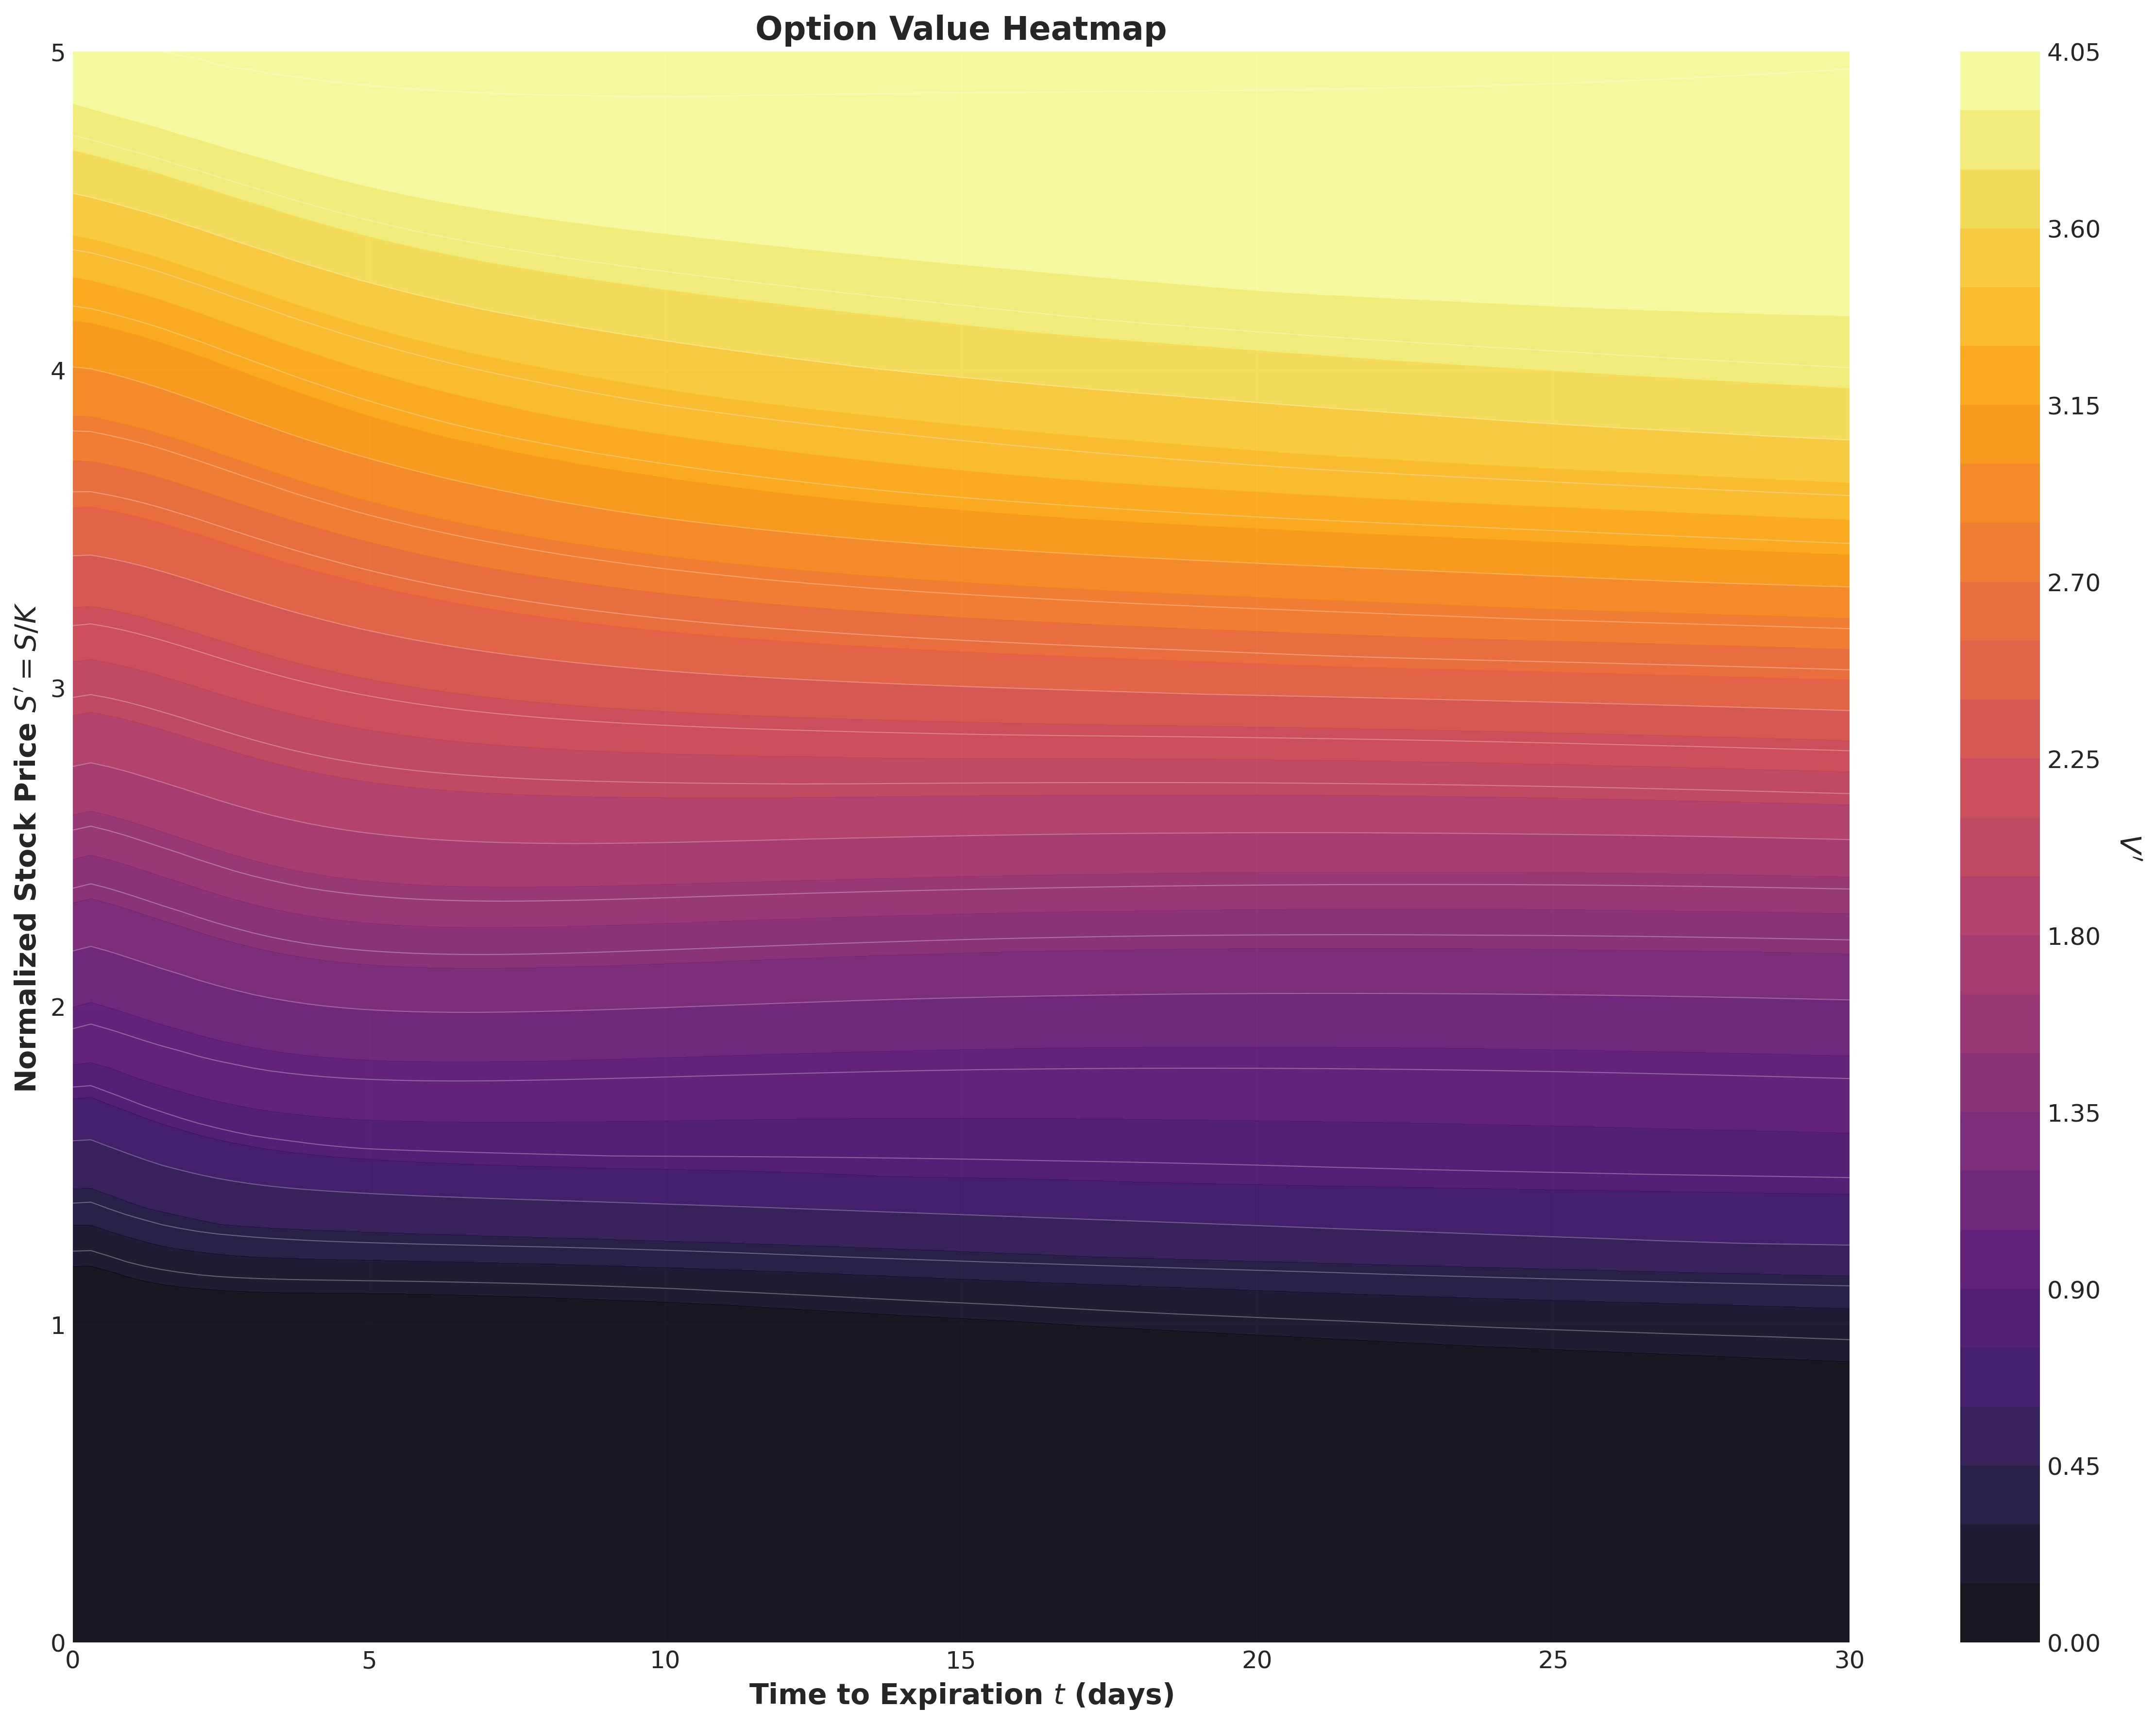

In [16]:
# Create contour plots for 2D analysis
plt.figure(figsize=(16, 12), facecolor='none')

# Contour plot 2: Heatmap with different colormap
contour2 = plt.contourf(cpu_T_grid, cpu_S_grid, cpu_V_prime, levels=30, cmap='inferno', alpha=0.9)
plt.contour(cpu_T_grid, cpu_S_grid, cpu_V_prime, levels=20, colors='white', alpha=0.3, linewidths=0.5)
plt.xlabel(r'Time to Expiration $t$ (days)', fontweight='bold', fontsize=14)
plt.ylabel(r'Normalized Stock Price $S^\prime = S/K$', fontweight='bold', fontsize=14)
plt.title('Option Value Heatmap', fontweight='bold', fontsize=16)
cbar2 = plt.colorbar(contour2)
cbar2.set_label(r"$V^\prime$", rotation=270, labelpad=20, fontweight='bold')

plt.tight_layout()
plt.savefig('pics/qstorm_contours.png', transparent=True, bbox_inches='tight', 
            facecolor='none', edgecolor='none', dpi=300)
print("Saved: qstorm_contours.png")
plt.show()


Saved: qstorm_standalone_315deg.png


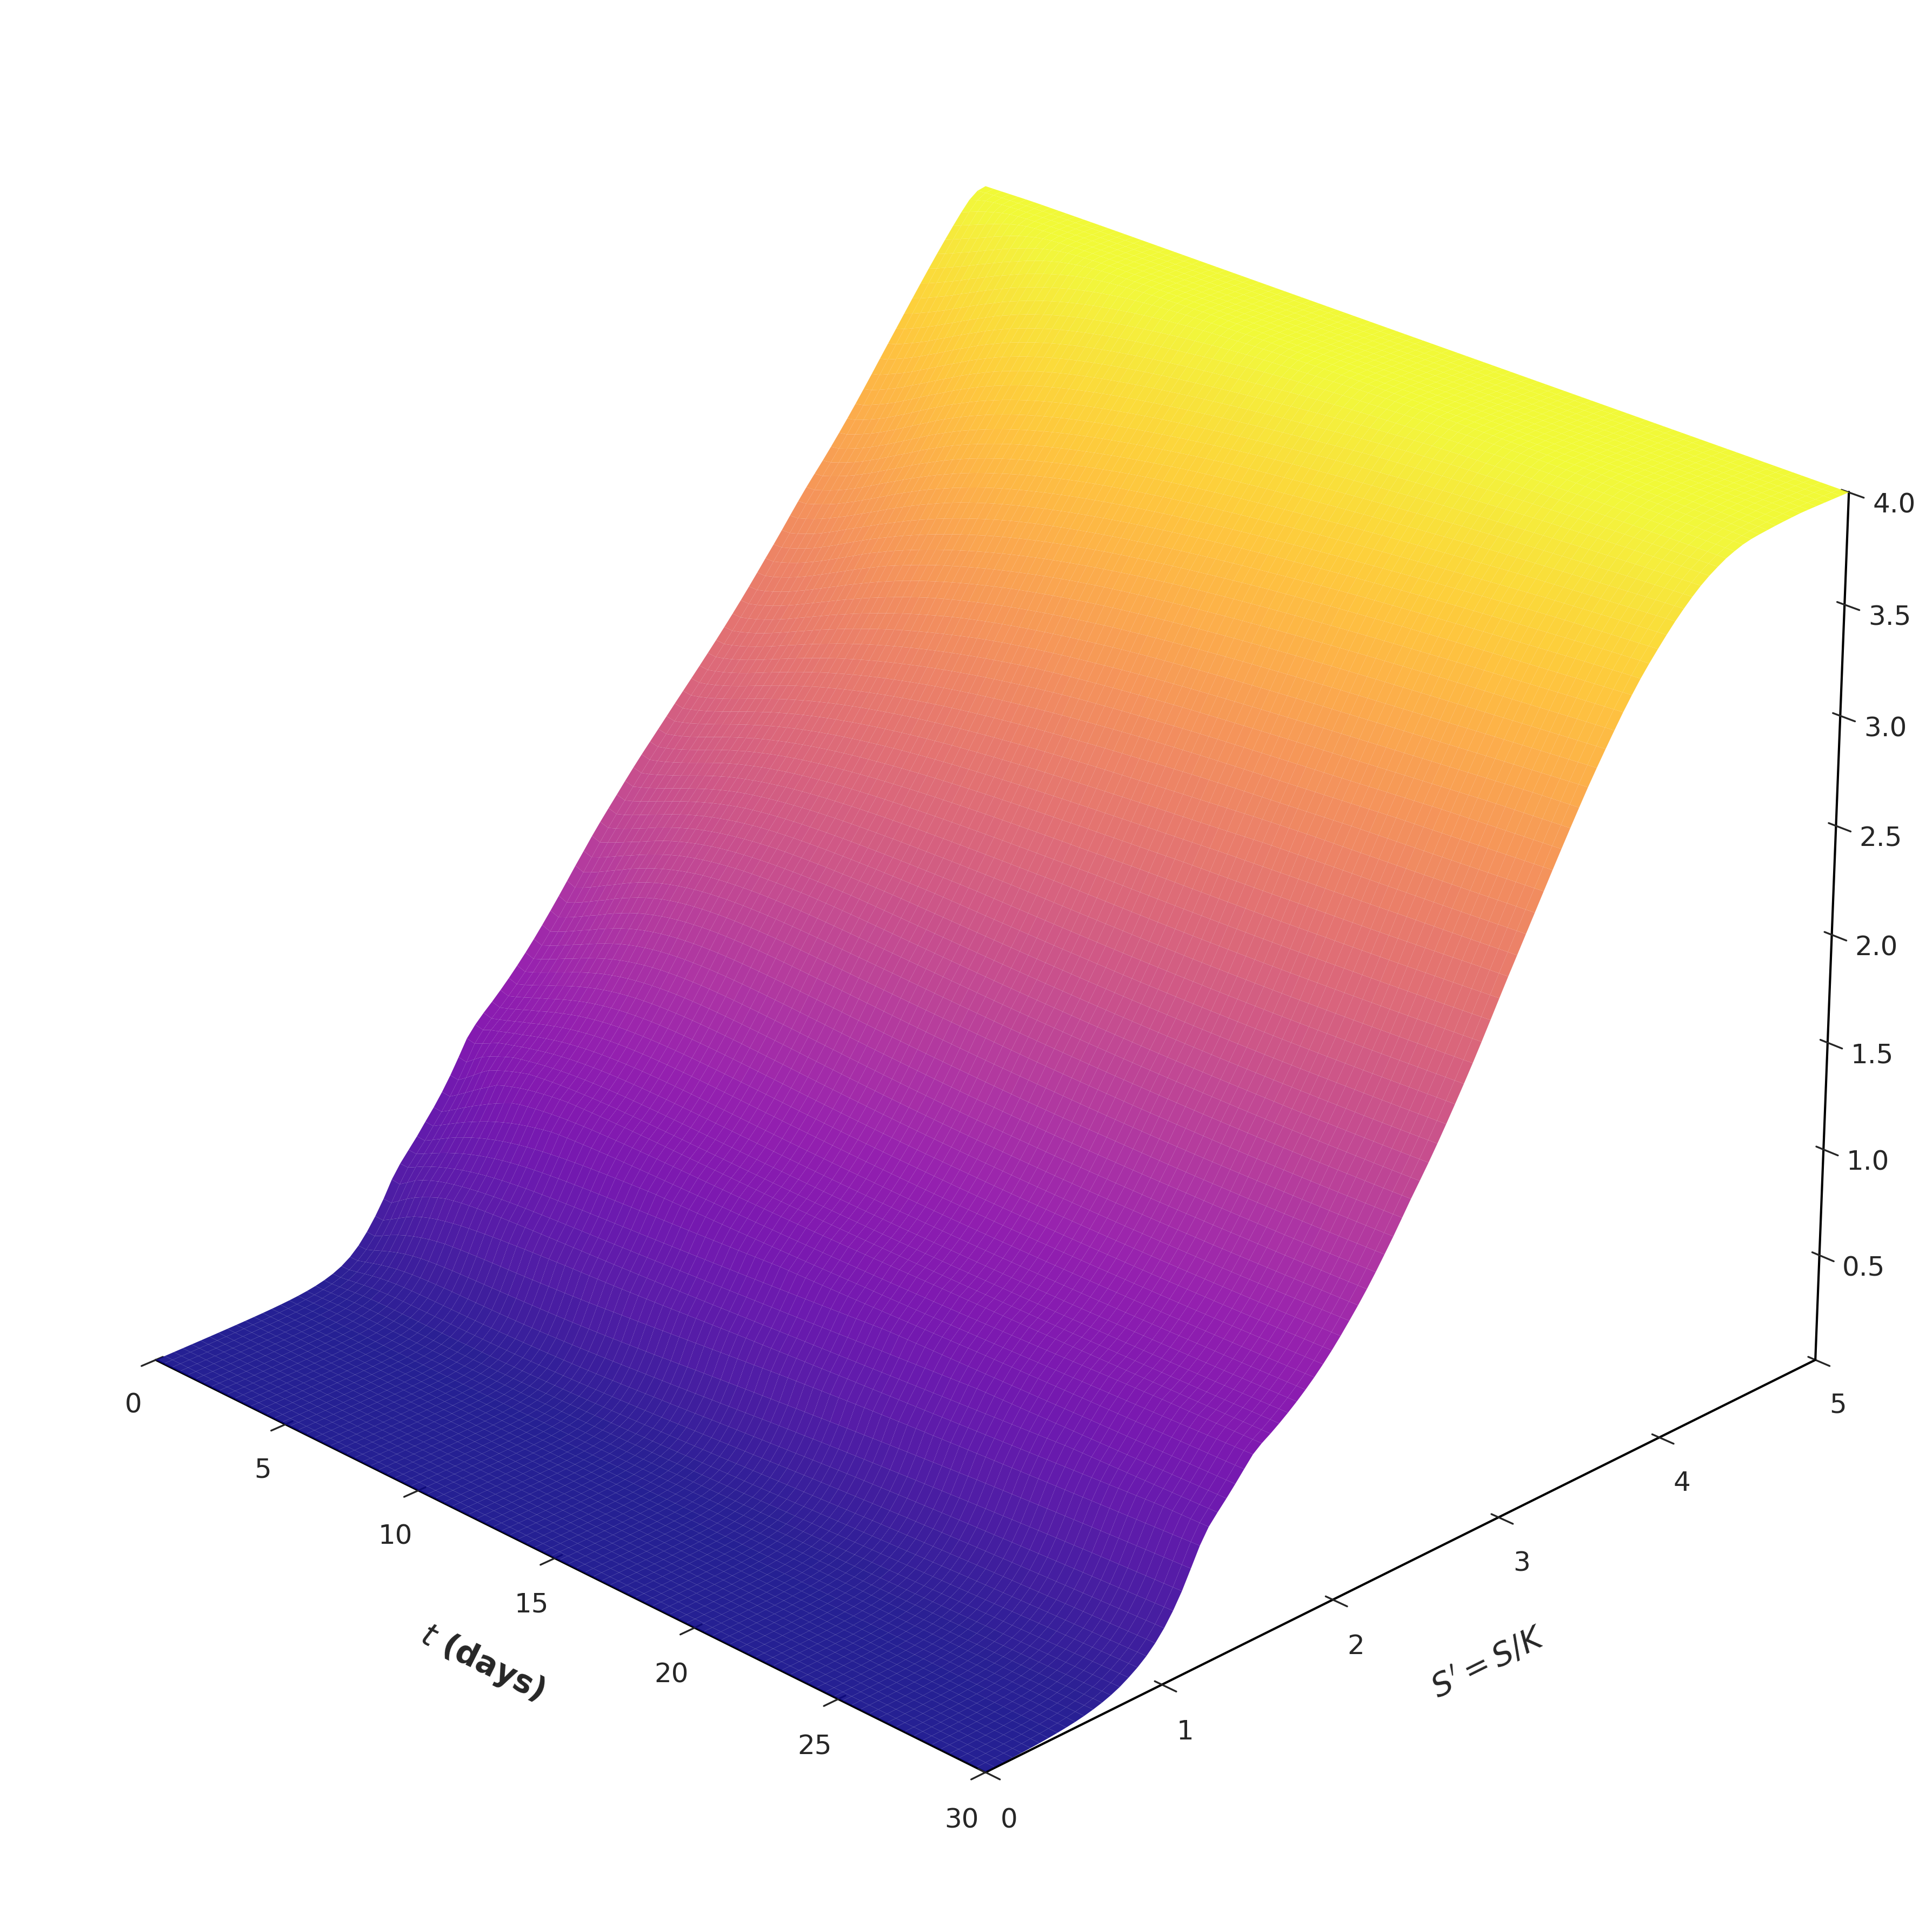

In [10]:
# Standalone version of the bottom-left view (elev=25°, azim=315°)
# This is a particularly nice angle showing the surface rise

fig = plt.figure(figsize=(16, 12), facecolor='white', edgecolor='none')
ax = fig.add_subplot(111, projection="3d")

# Make axes background completely transparent
ax.patch.set_facecolor('white')
ax.patch.set_alpha(0.0)

# Create surface with high quality settings
surf = ax.plot_surface(
    cpu_T_grid, 
    cpu_S_grid, 
    cpu_V_prime,
    cmap='plasma',
    edgecolor='none',
    alpha=0.9,
    linewidth=0,
    antialiased=True,
    shade=True,
    rstride=1,
    cstride=1
)

# Set transparent background - completely remove all grey panes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')
ax.xaxis.pane.set_alpha(0.0)
ax.yaxis.pane.set_alpha(0.0)
ax.zaxis.pane.set_alpha(0.0)

# Remove grid lines completely for cleaner look
ax.grid(False)

# Make axes lines more subtle or remove them
ax.xaxis.line.set_color('black')
ax.yaxis.line.set_color('black')
ax.zaxis.line.set_color('black')
ax.xaxis.line.set_linewidth(1.0)
ax.yaxis.line.set_linewidth(1.0)
ax.zaxis.line.set_linewidth(1.0)

# Labels with LaTeX formatting for publication
ax.set_xlabel(r'$t$ (days)', labelpad=15, fontweight='bold')
ax.set_ylabel(r'$S^\prime = S/K$', labelpad=15, fontweight='bold')
ax.set_zlabel(r'$V^\prime = V/K$', labelpad=15, fontweight='bold')
#ax.set_title('qStorm Option Pricing Surface', pad=20, fontweight='bold', fontsize=18)

# Set the specific viewing angle from bottom-left view
ax.view_init(elev=25, azim=315)

# Add colorbar with professional styling
#cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20, pad=0.1)
#cbar.set_label(r'Option Value $V^\prime$', rotation=270, labelpad=20, fontweight='bold', fontsize=14)
#cbar.ax.tick_params(labelsize=12)

# Set axis limits for better visualization
ax.set_xlim(cpu_T_grid.min(), cpu_T_grid.max())
ax.set_ylim(cpu_S_grid.min(), cpu_S_grid.max())
ax.set_zlim(cpu_V_prime.min(), cpu_V_prime.max())

# Add subtle lighting effect by adjusting the surface
ax.set_box_aspect([1, 1, 0.8])

plt.tight_layout()

# Save with completely transparent background (no grey at all)
plt.savefig('pics/qstorm_standalone_315deg.png', transparent=True, bbox_inches='tight', 
            facecolor='white', edgecolor='none', dpi=300, pad_inches=0.1)
print("Saved: qstorm_standalone_315deg.png")

plt.show()


In [11]:
# Import utilities for PDF generation
from utils.dist_utils import generate_smooth_pdf
from varpi.wasserstein_min import get_best_lstm_pdf_params
import numpy as np
from utils.optuna_utils import load_qlstm_model


_, qlstm_params = load_qlstm_model()

# Get PDF parameters
pdf_params = get_best_lstm_pdf_params(_)

# Extract varphi quantiles from sampled point
varphi_quants_np = varphi_q.cpu().detach().numpy().squeeze()
taus_np = np.array(taus)

# Generate PDF from varphi quantiles
varphi_grid, varphi_pdf, varphi_cdf = generate_smooth_pdf(
    varphi_quants_np, taus_np, **pdf_params
)

print(f"Varphi PDF range: [{varphi_grid.min():.4f}, {varphi_grid.max():.4f}]")
print(f"Varphi PDF max density: {varphi_pdf.max():.4f}")


/home/dev/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17780297705940562 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)
[I 2026-02-09 14:31:58,708] Using an existing study with name 'wasserstein_distance_qlstm' instead of creating a new one.


Varphi PDF range: [-0.1070, 0.1095]
Varphi PDF max density: 50.2789


Saved: varphi_pdf.png


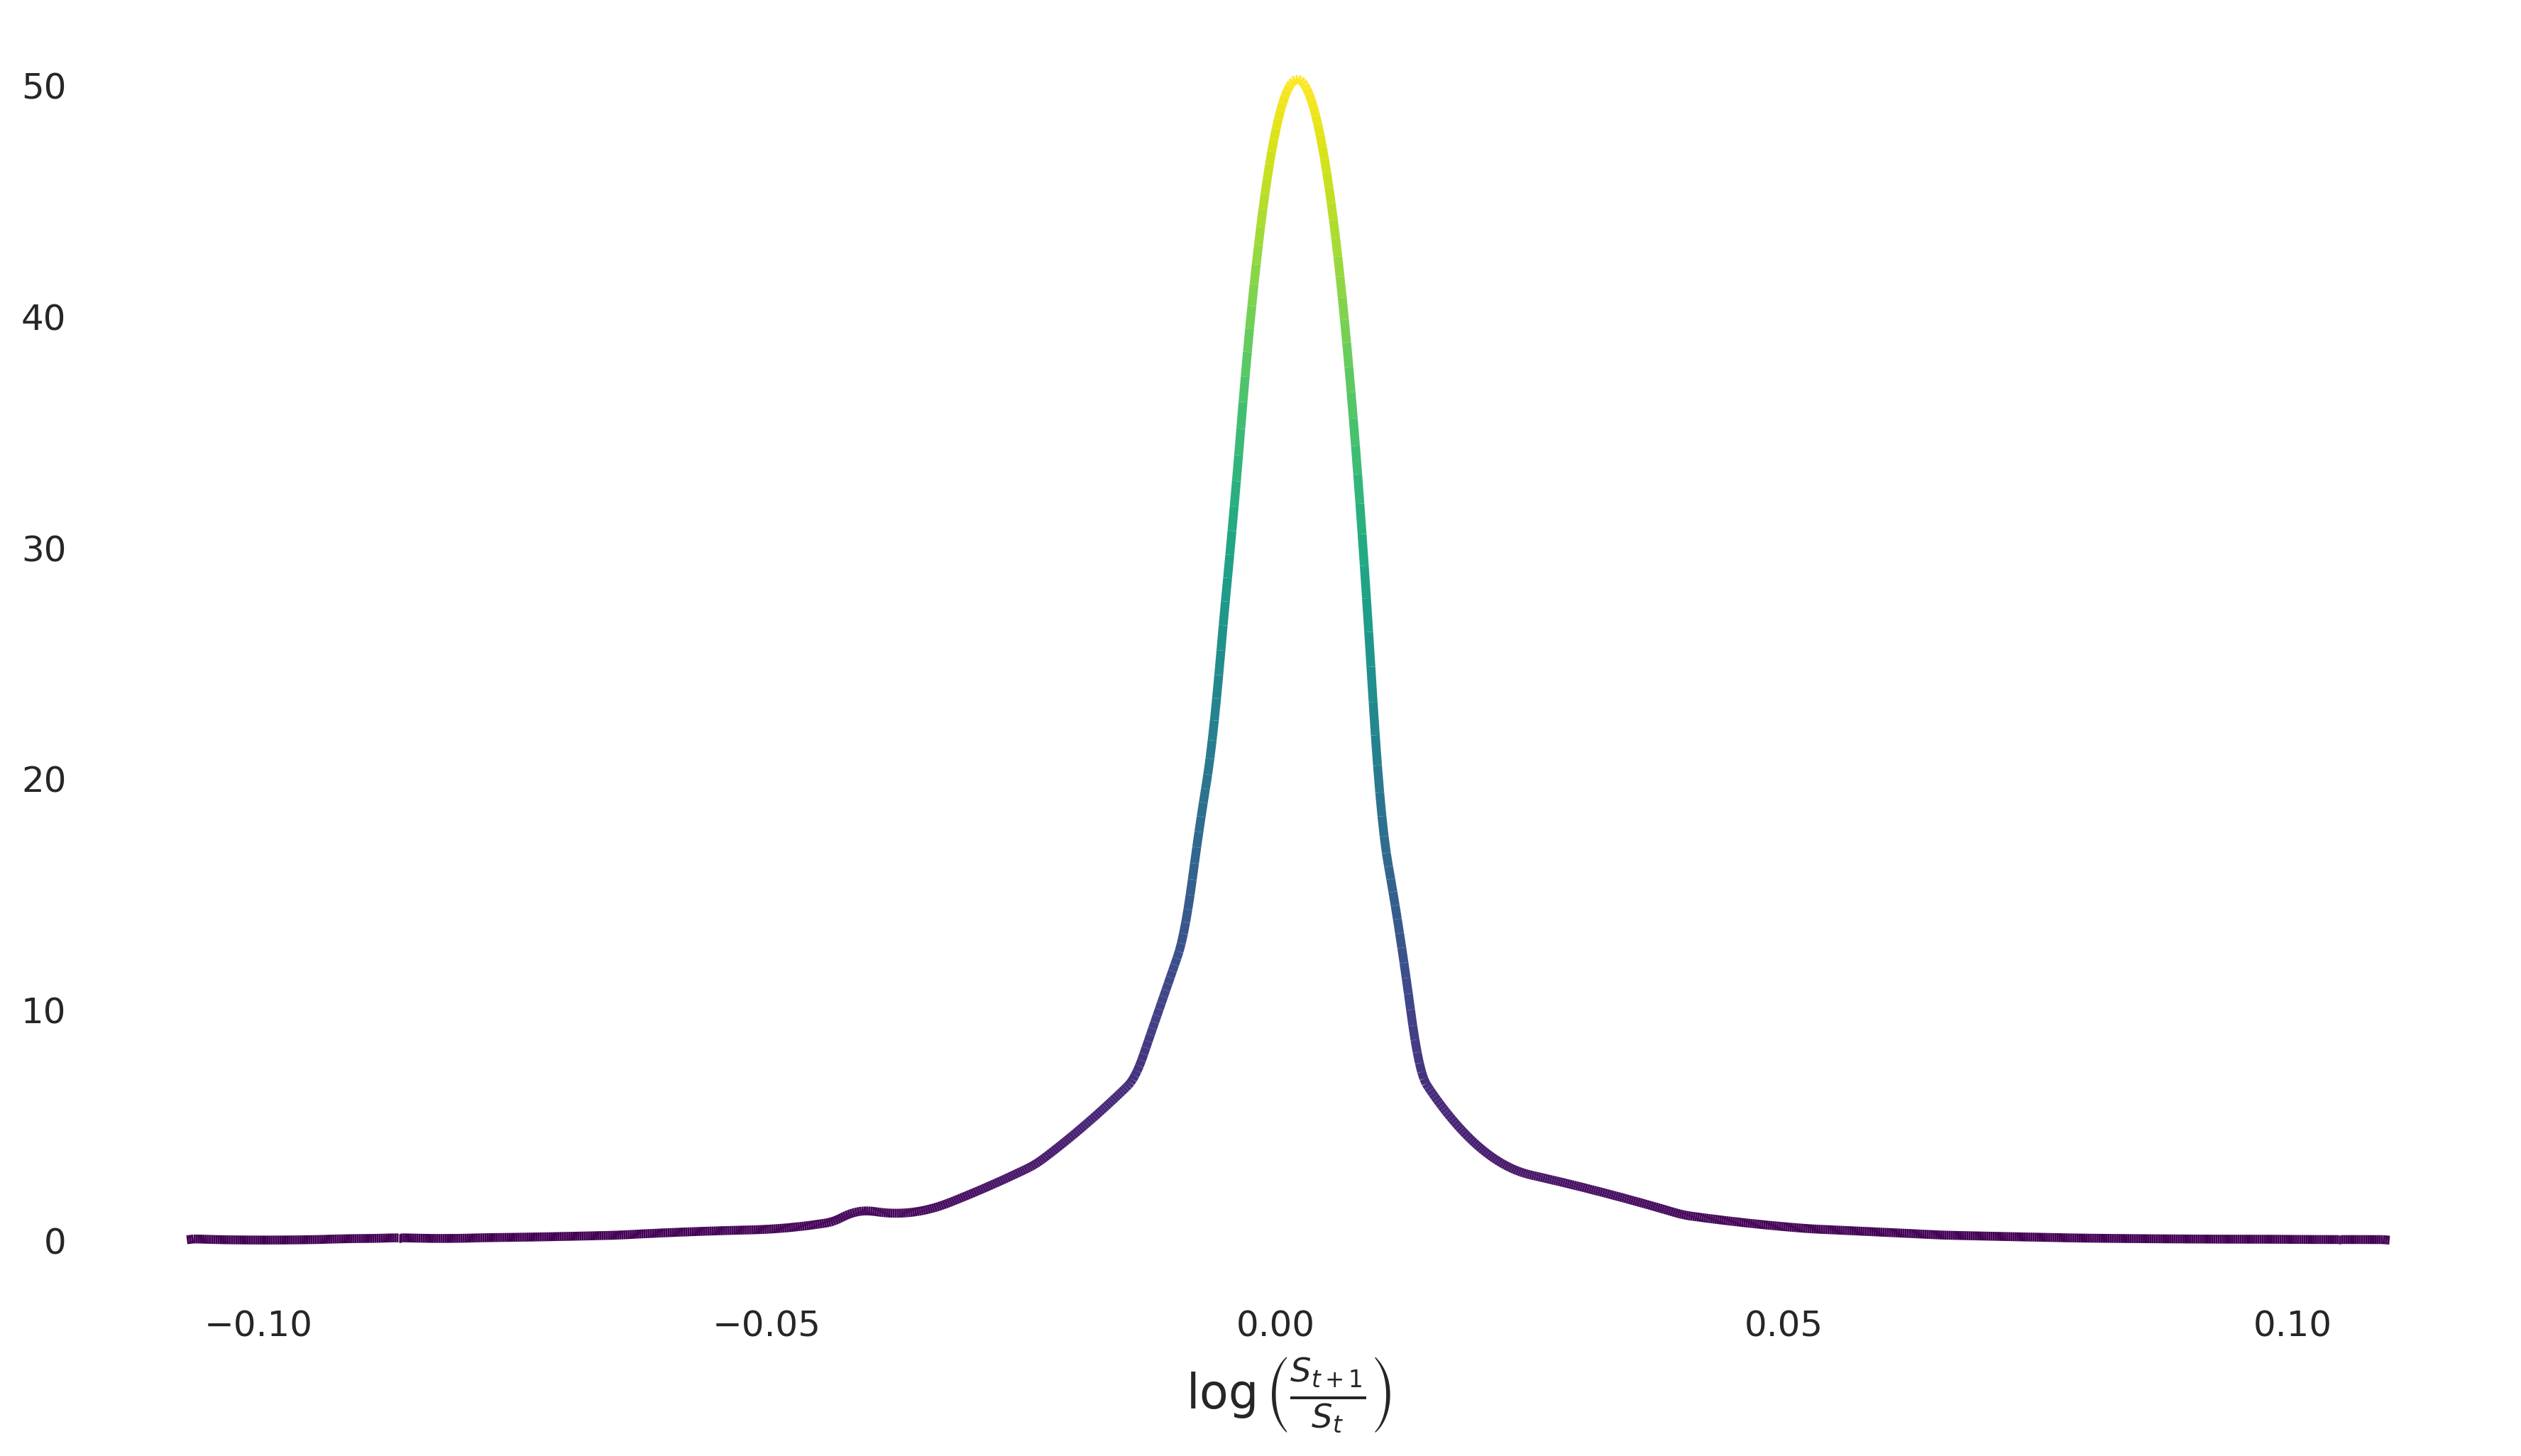

In [12]:
from matplotlib.collections import LineCollection
from matplotlib import cm, colors

# Beautiful varphi PDF visualization with plain white background
fig, ax = plt.subplots(figsize=(12, 7), facecolor='white')

# Build line segments
points = np.array([varphi_grid, varphi_pdf]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize color along the curve (by PDF height)
norm = colors.Normalize(vmin=varphi_pdf.min(), vmax=varphi_pdf.max())
cmap = cm.viridis  # SAME colormap as surface

lc = LineCollection(
    segments,
    cmap=cmap,
    norm=norm,
    linewidth=3,
    zorder=3
)
lc.set_array(varphi_pdf)

ax.add_collection(lc)

# Fill under curve using the colormap's mid-tone
ax.fill_between(
    varphi_grid,
    varphi_pdf,
    color=cmap(0.55),
    alpha=0.0,
    zorder=2
)

# Labels
ax.set_xlabel(r'$\log\left(\frac{S_{t+1}}{S_{t}}\right)$',
              fontsize=16, fontweight='bold')

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5, zorder=1)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig(
    'pics/varphi_pdf.png',
    transparent=True,
    bbox_inches='tight',
    facecolor='white',
    edgecolor='none',
    dpi=300
)
print("Saved: varphi_pdf.png")
plt.show()


Saved: qstorm_all_views.png


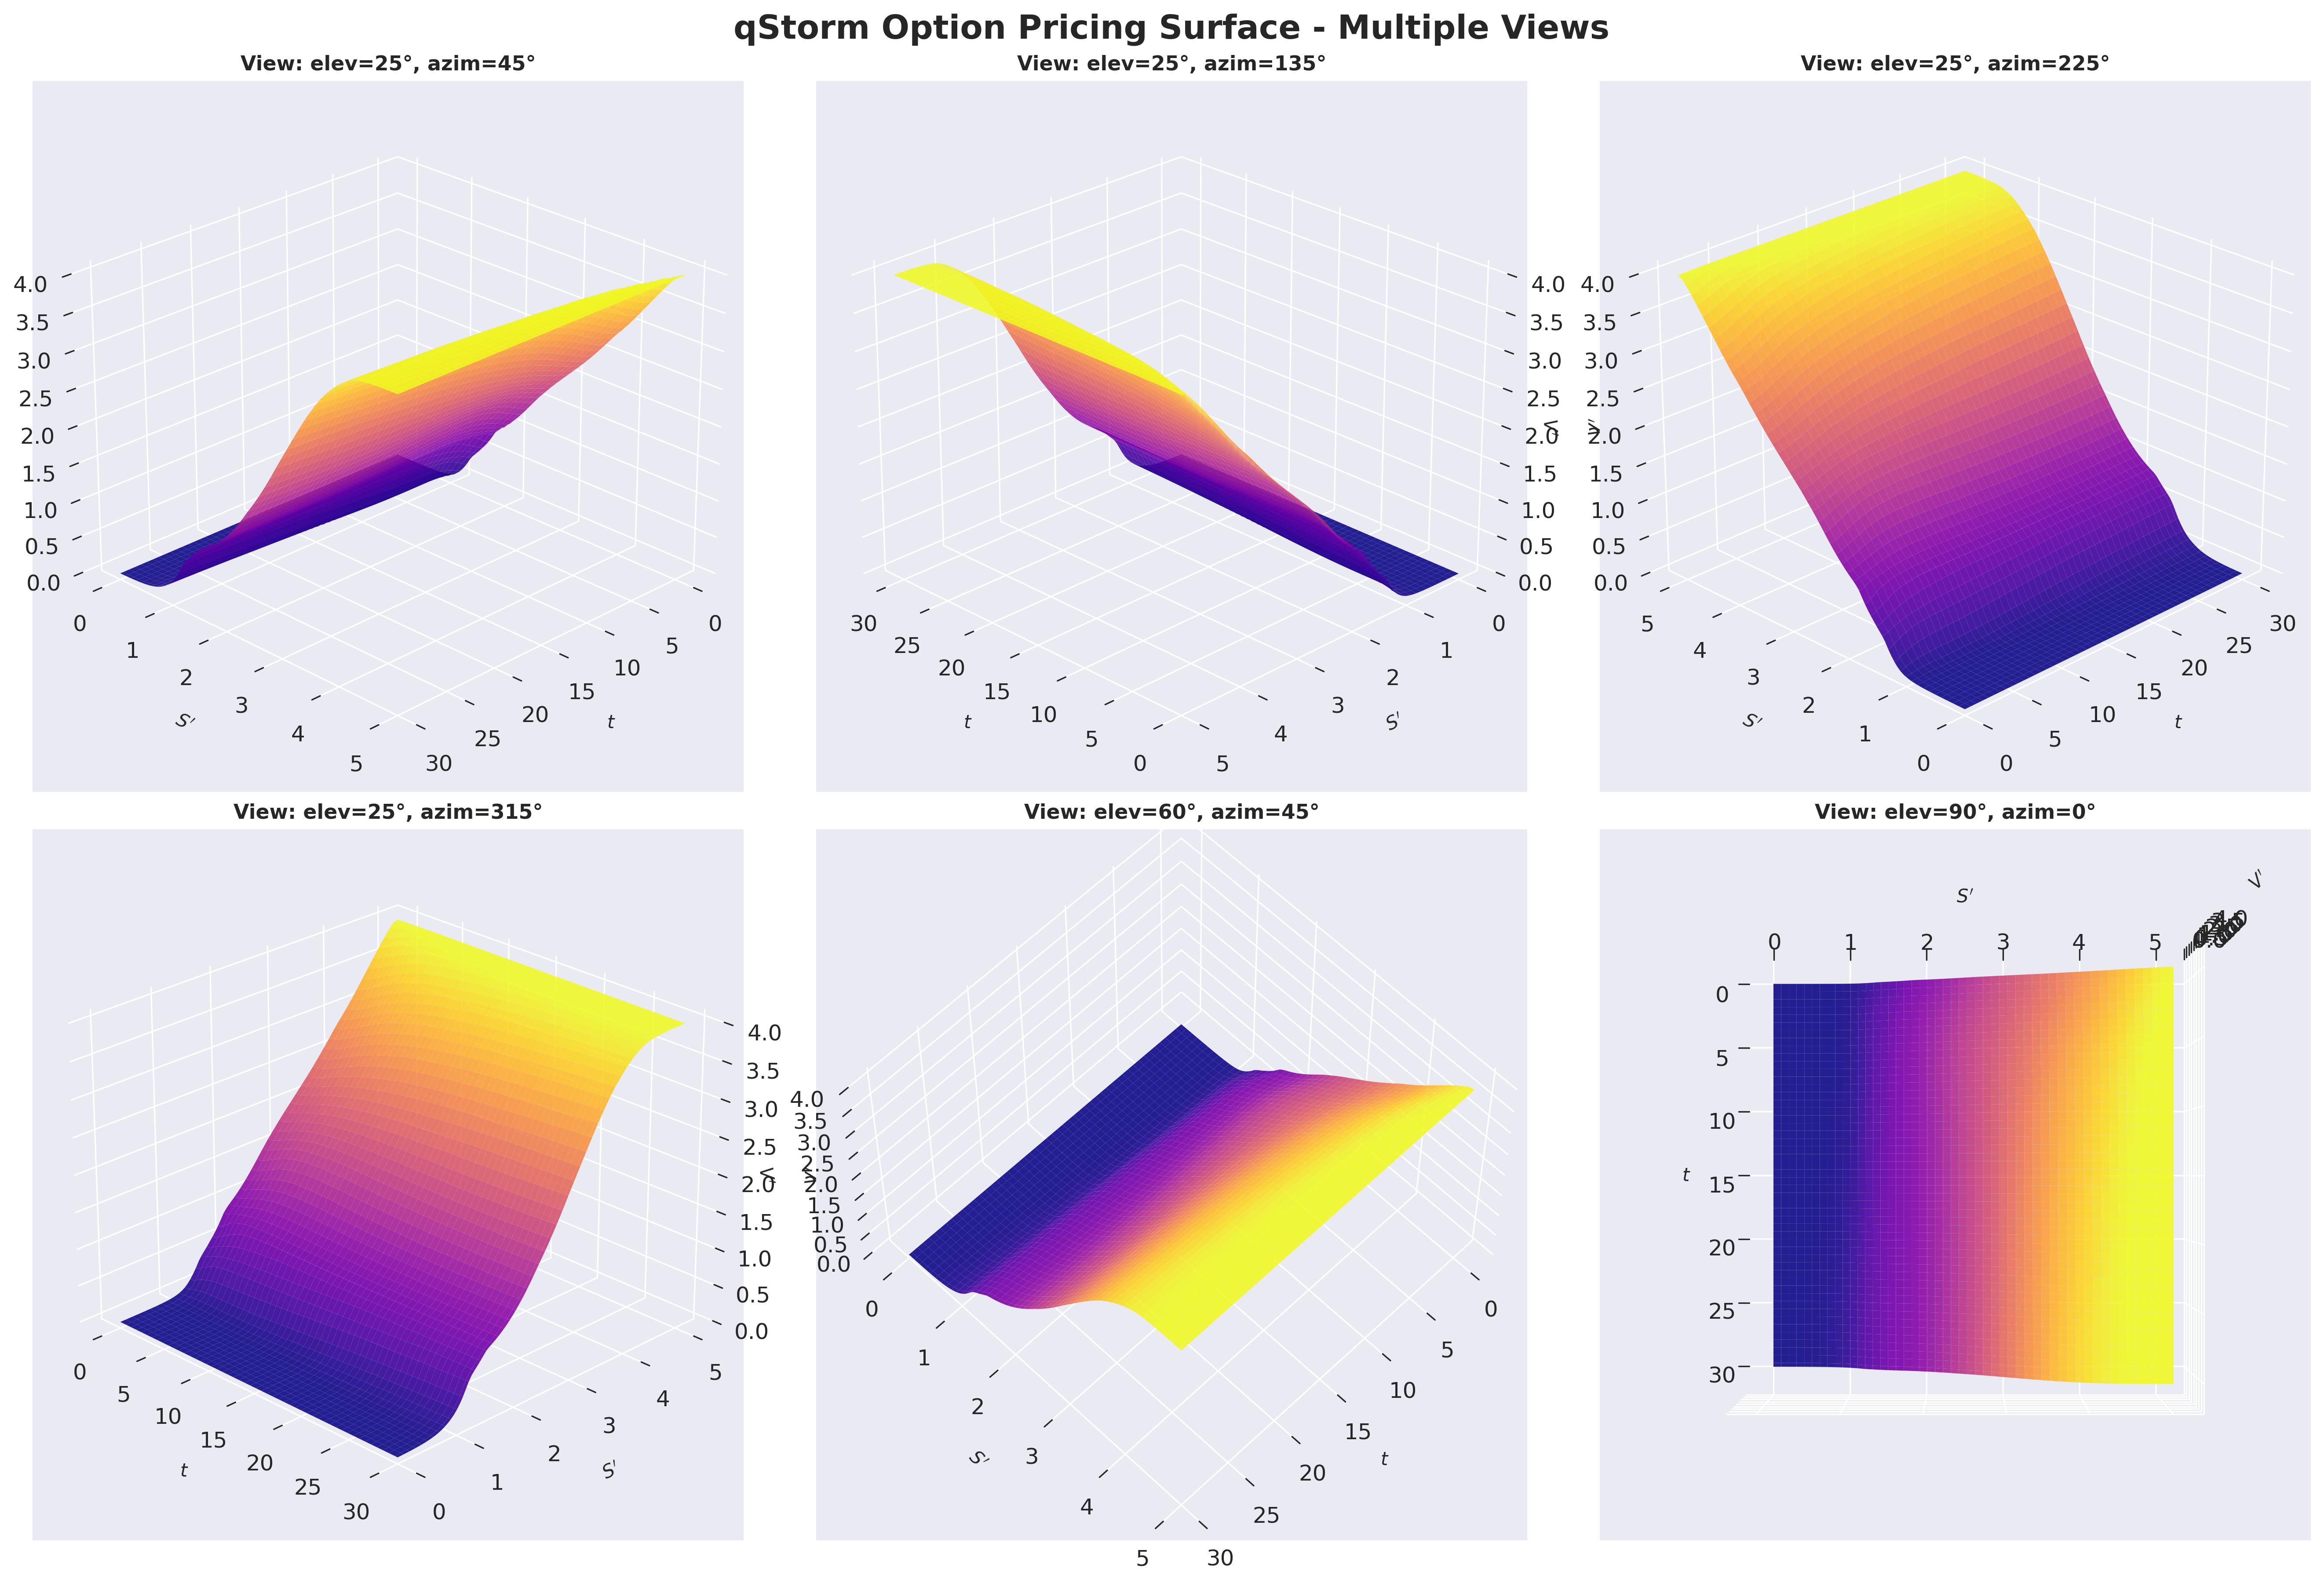

In [13]:
# Create an animated rotation (optional - saves as static frames)
# This creates multiple angles for animation or selection
angles = [(25, 45), (25, 135), (25, 225), (25, 315), (60, 45), (90, 0)]

fig = plt.figure(figsize=(18, 12), facecolor='none')
for idx, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 3, idx+1, projection="3d")
    surf = ax.plot_surface(cpu_T_grid, cpu_S_grid, cpu_V_prime, cmap='plasma', 
                           edgecolor='none', alpha=0.9, antialiased=True)
    ax.set_xlabel(r'$t$', labelpad=8, fontsize=10)
    ax.set_ylabel(r"$S^\prime$", labelpad=8, fontsize=10)
    ax.set_zlabel(r"$V^\prime$", labelpad=8, fontsize=10)
    ax.set_title(f'View: elev={elev}°, azim={azim}°', fontsize=11, fontweight='bold')
    ax.view_init(elev=elev, azim=azim)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_alpha(0.0)
    ax.yaxis.pane.set_alpha(0.0)
    ax.zaxis.pane.set_alpha(0.0)

plt.suptitle('qStorm Option Pricing Surface - Multiple Views', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('pics/qstorm_all_views.png', transparent=True, bbox_inches='tight', 
            facecolor='none', edgecolor='none', dpi=300)
print("Saved: qstorm_all_views.png")
plt.show()


In [14]:
num_time_points = 100  # High resolution for smooth surface
time_normalized = np.linspace(0.0, 1.0, num_time_points)
print(f"Sampling {num_time_points} normalized time points (0.0 to 1.0)...")

# Prepare varphi_q input
if len(varphi_q.shape) == 1:
    varphi_q_input = varphi_q.unsqueeze(0)  # (1, num_quantiles)
else:
    varphi_q_input = varphi_q  # Already 2D

# Compute varpi quantiles and PDFs for each normalized time point
all_grids = []
all_pdfs = []
all_times_norm = []

print("Computing VarPi distributions...")
for i, t_norm in enumerate(time_normalized):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i+1}/{num_time_points}")
    
    # Convert normalized time back to days for VarPi model
    # t_norm goes from 0 to 1, map to days 1 to 30
    t_day = 1 + t_norm * 29  # Maps 0->1, 1->30
    T_clipped = max(t_day, 15)
    t_varpi = t_day / T_clipped
    T_varpi = T_clipped / 30
    
    # Get varpi quantiles
    with torch.no_grad():
        t_tensor = torch.tensor([[t_varpi]], device=device, dtype=torch.float32)
        T_tensor = torch.tensor([[T_varpi]], device=device, dtype=torch.float32)
        varpi_quants = varpi(varphi_q_input, t_tensor, T_tensor)
        varpi_quants_np = varpi_quants.cpu().detach().numpy().squeeze()
    
    # Generate PDF
    varpi_grid_full, varpi_pdf_full, _ = generate_smooth_pdf(varpi_quants_np, taus_np, **pdf_params)
    all_grids.append(varpi_grid_full)
    all_pdfs.append(varpi_pdf_full)
    all_times_norm.append(t_norm)

print("Interpolating to common grid...")
# Find common grid range for all PDFs
all_grid_min = min([g.min() for g in all_grids])
all_grid_max = max([g.max() for g in all_grids])
# Match the reference: Returns from ~-0.3 to 0.4
common_grid = np.linspace(all_grid_min, all_grid_max, 200)

# Interpolate all PDFs to common grid
pdf_matrix = []
for grid, pdf in zip(all_grids, all_pdfs):
    pdf_interp = np.interp(common_grid, grid, pdf)
    # Smooth the interpolated PDF slightly
    from scipy.ndimage import gaussian_filter1d
    pdf_interp = gaussian_filter1d(pdf_interp, sigma=0.8)
    pdf_matrix.append(pdf_interp)

pdf_matrix = np.array(pdf_matrix)  # Shape: (num_time_points, num_grid_points)
time_matrix = np.array(all_times_norm)  # Normalized time 0.0 to 1.0

# Prune low-density regions - similar to reference plot
max_density = np.nanmax(pdf_matrix)
density_threshold = max_density * 0.02  # 2% threshold for cleaner edges

# Apply threshold - set low values to NaN
pdf_matrix_pruned = pdf_matrix.copy()
pdf_matrix_pruned[pdf_matrix_pruned < density_threshold] = np.nan

# Use all data (no aggressive trimming)
time_matrix_pruned = time_matrix
common_grid_pruned = common_grid

# Create meshgrid for 3D plotting with pruned data
T_mesh, R_mesh = np.meshgrid(time_matrix_pruned, common_grid_pruned, indexing='ij')
P_mesh = pdf_matrix_pruned

Sampling 100 normalized time points (0.0 to 1.0)...
Computing VarPi distributions...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100
Interpolating to common grid...


Saved: varpi_full_evolution_3d.png


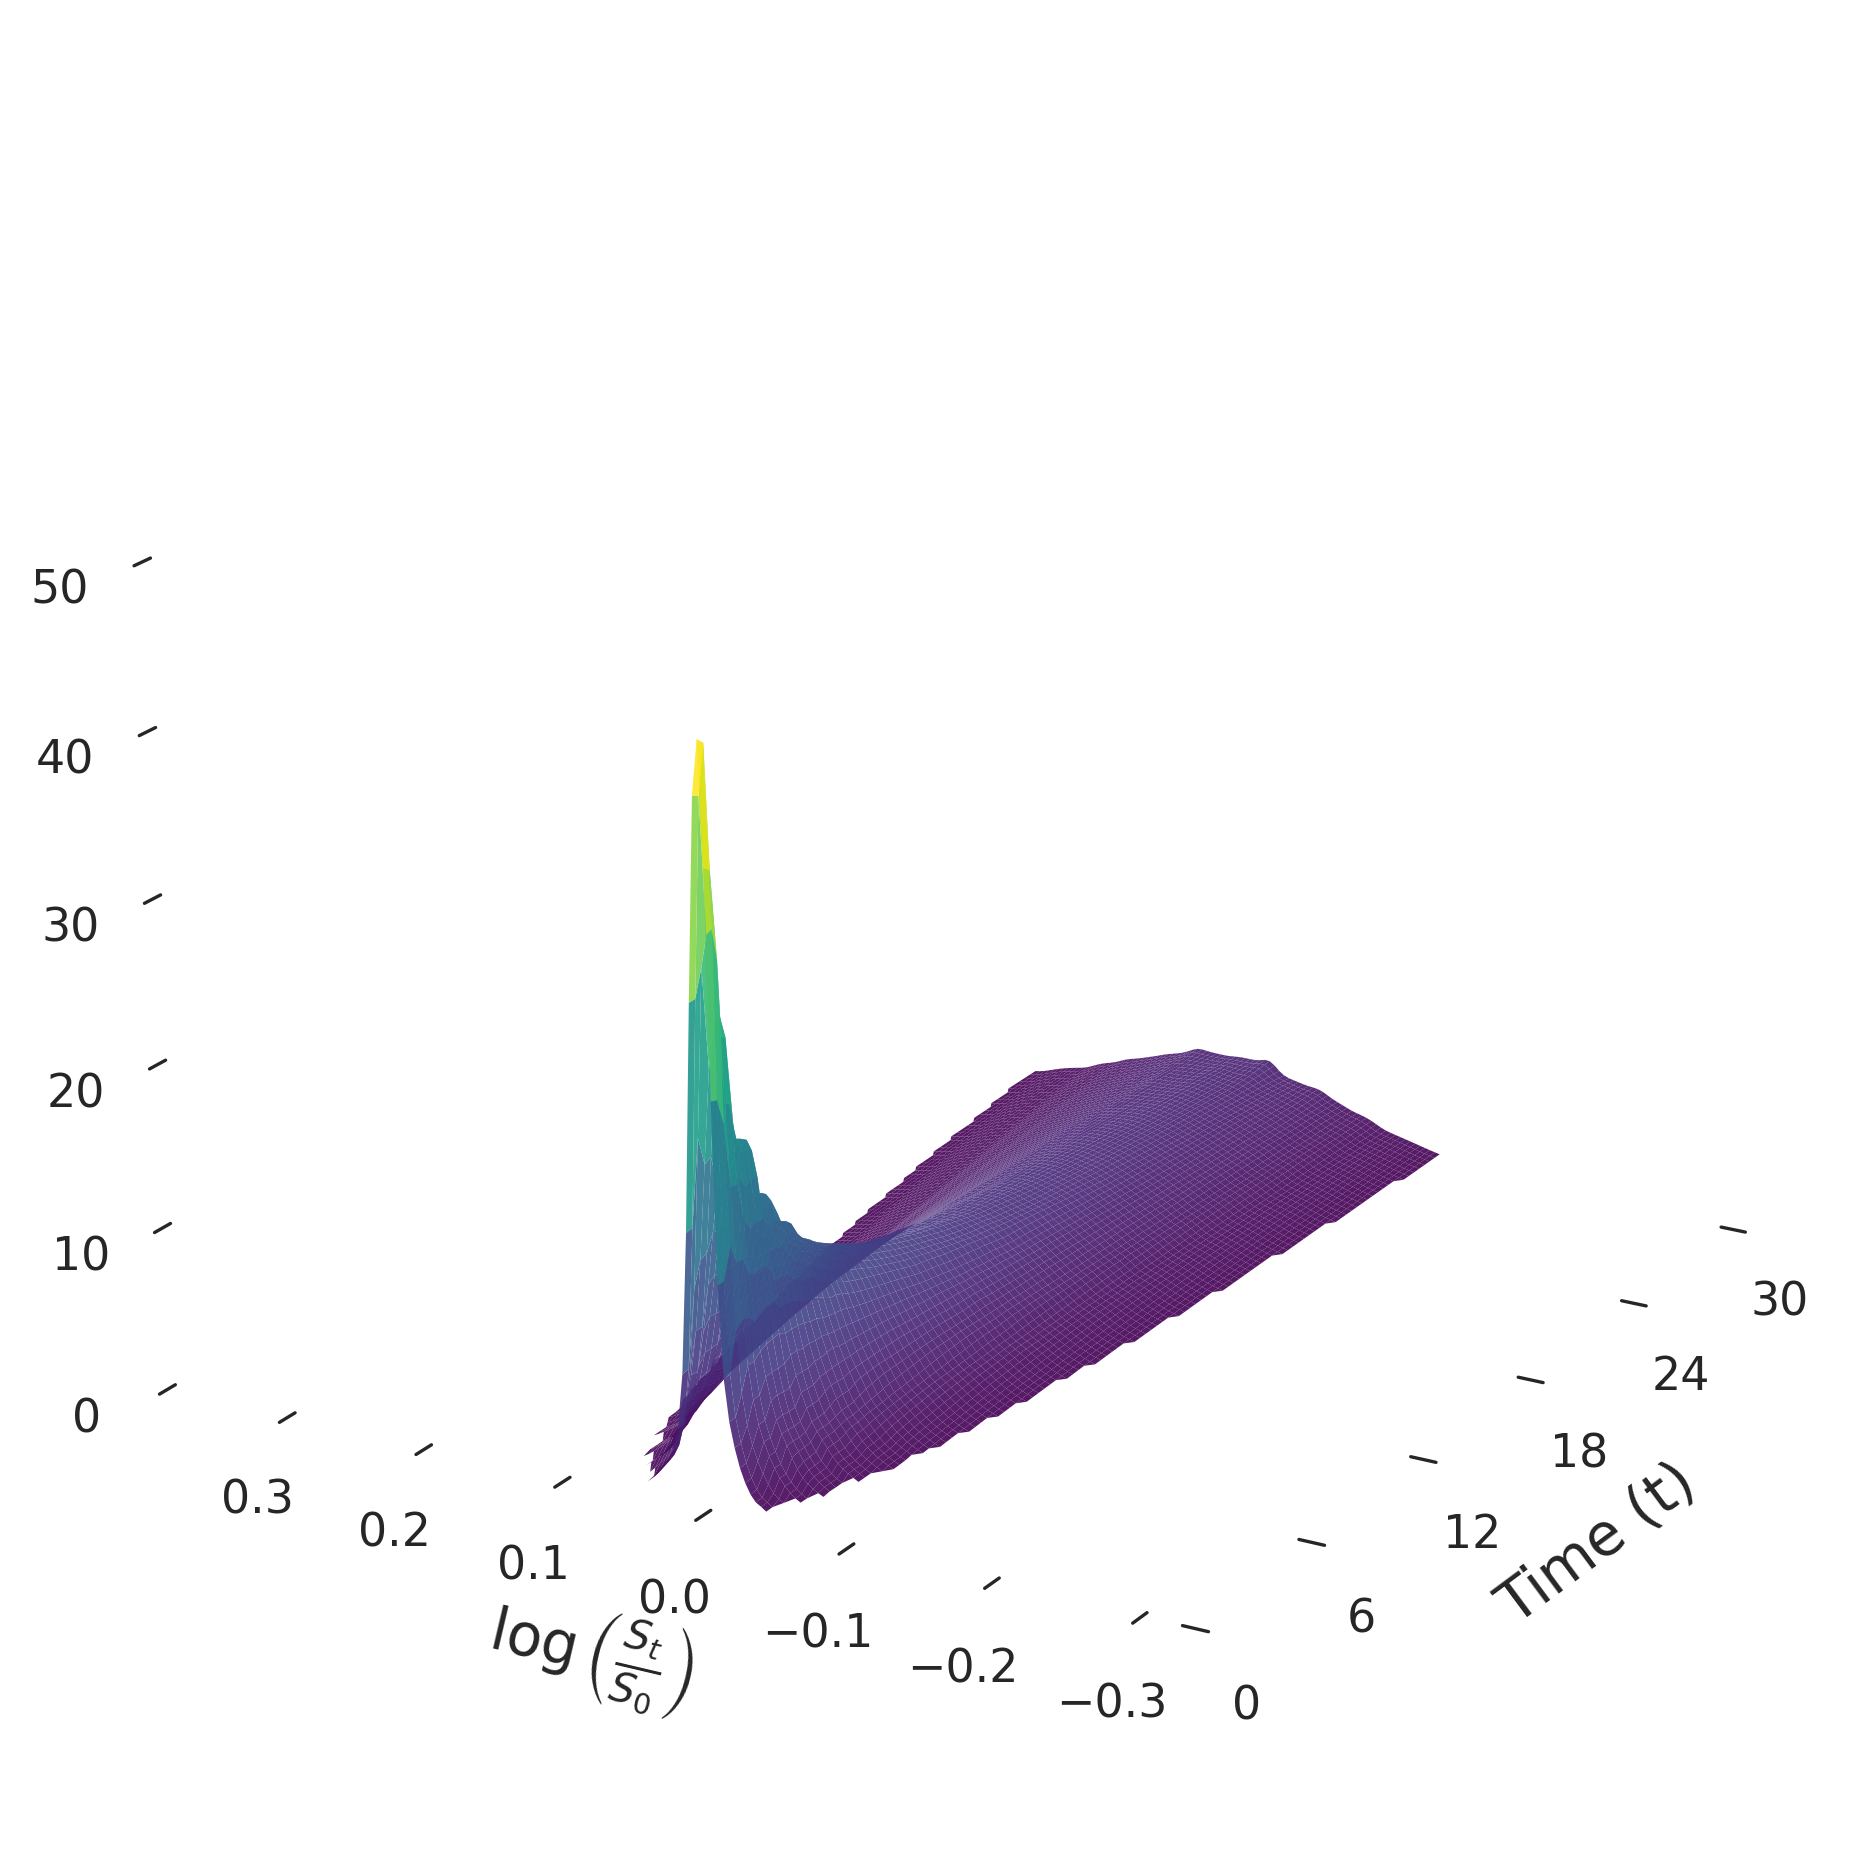

In [15]:
from matplotlib.ticker import FuncFormatter
fig = plt.figure(figsize=(10, 6), facecolor='white')
ax = fig.add_subplot(111, projection='3d')

# Use subplots_adjust instead of set_position
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
colormap_choice = 'viridis'

# Plot surface matching reference style
surf = ax.plot_surface(
    T_mesh, R_mesh, P_mesh,
    cmap=colormap_choice,
    edgecolor='none',
    alpha=0.9,
    linewidth=0,
    antialiased=True,
    shade=True,
    rstride=1,
    cstride=1
)

# Completely transparent background - no grey at all
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')
ax.xaxis.pane.set_alpha(0.0)
ax.yaxis.pane.set_alpha(0.0)
ax.zaxis.pane.set_alpha(0.0)

# Remove all grid lines for cleaner look
ax.grid(False)

# Labels matching reference plot style
ax.set_xlabel(r'Time (t)', labelpad=6, fontsize=14)
ax.set_ylabel(r'$\log\left(\frac{S_t}{S_0}\right)$', labelpad=6, fontsize=14)
#ax.set_title(r'PDF Evolution Over Time', pad=15, fontsize=16, fontweight='bold')

# Viewing angle to match reference
ax.view_init(elev=20, azim=210)

# Colorbar matching reference style
#cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20, pad=0.1)
#cbar.set_label(r'Density', rotation=270, labelpad=15, fontsize=12)
#cbar.ax.tick_params(labelsize=11)

# Set axis limits to match reference (normalized time 0-1)
# because t is normalized to 0-1 we need to multiply by 30 to get the actual time
ax.set_xlim(0, 1)
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x*30:g}")
)
ax.set_ylim(common_grid_pruned.min(), common_grid_pruned.max())
z_valid = P_mesh[~np.isnan(P_mesh)]
if len(z_valid) > 0:
    z_max = z_valid.max()
    ax.set_zlim(0, z_max * 1.1)

# Aspect ratio
#ax.set_box_aspect([1, 1, 0.6])

# Tick formatting
ax.tick_params(labelsize=11)

# White background
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

#plt.tight_layout()
plt.savefig(
    'pics/varpi_full_evolution_3d.png',
    dpi=300,
    transparent=True,
    bbox_inches=None,  # Explicitly set to None
    pad_inches=0
)
print("Saved: varpi_full_evolution_3d.png")
plt.show()
